# Определение стоимости автомобилей

**Описание проекта**: Сервис по продаже автомобилей с пробегом «Не бит, не крашен» разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Цель исследования**: Построить модель машинного обучения для определения стоимости автомобиля на основе исторических данных: технические характеристики, комплектации и цены.
Заказчику важны:

- качество предсказания;
- скорость предсказания;
- значение метрики RMSE должно быть меньше 2500;
- время обучения.

**Ход исследования:**

- *Шаг 1.* Подготовка и предобработка данных.
- *Шаг 2.* Обучение моделей. 
- *Шаг 3.* Анализ моделей.
- *Шаг 4.* Выводы.


**Общий вывод**: По итогам проведенного анализа и разработки модели машинного обучения появится возможность узнать рыночную стоимость своего автомобиля. 

**Описание данных**

Данные имеют следующие признаки:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро) — **целевой признак**

In [1]:
# Установим библиотеки, которые понадобятся для работы над проектом. 
!pip install -q phik
!pip install -q lightgbm

# Обновляем scikit-learn, так как выдавал ошибки
!pip install -Uq scikit-learn

<div class="alert alert-info">
У меня вопрос. В этом проекте я не смогла посчитать метрику RMSE так как делала это раньше, выдавало ошибку. Поискала в интернете и нашла, что это может возникнуть из-за версий библиотеки scikit-learn, но обновление тоже не помогло. Подскажи, пожалуйста, как можно это исправить?

*Код:*
    `rmse = mean_squared_error(y_test, y_test_pred, squared=False)`

*Ошибка:*
    `TypeError: got an unexpected keyword argument 'squared'` 
</div>

In [2]:
# Импортируем библиотеки, которые понадобятся для работы над проектом. 
import time
import warnings
import math

# для датафрейма 
import pandas as pd
import numpy as np

# для визуализации 
import matplotlib
import matplotlib.pyplot as plt 
import seaborn as sns

# для статистики
import phik
from phik import report
from phik.report import plot_correlation_matrix

# для машинного обучения
import sklearn
from sklearn.model_selection import train_test_split, RandomizedSearchCV  
from sklearn.preprocessing import StandardScaler, MinMaxScaler, RobustScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

# модели 
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from lightgbm import LGBMRegressor

# метрики
from sklearn.metrics import mean_squared_error

In [3]:
# Зафисируем константы

RANDOM_STATE = 42

## Загрузка и подготовка данных

### Загрузка данных 

In [4]:
# Считаем данные из csv-файла в датафрейм и сохраним в переменную. 

try:
    df = pd.read_csv('/datasets/autos.csv')
except:
    df = pd.read_csv('https://code.s3.yandex.net/datasets/autos.csv')

In [5]:
# Функция вывода основной информации о файлах-датафреймах

def main_info(df):
    # Информация о структуре датафрейма
    print("Информация о структурах:")
    display(df.info())
    print("\n")
    display(df.shape)
    print('-----')
    
    # Статистическое описание колонок
    print("Статистика:")
    display(df.describe().T)
    print("\n")
    print('-----')
    
    # Первые десять строк датафрейма
    print("Первые строки:")
    display(df.head(10))
    print("\n")
    print('-----')
    
    # Информация о дубликатах
    print("Количество явных дубликатов в датафрейме:")
    display(df.duplicated().sum())
    print("\n")
    print('-----')
    
    # Информация о пропусках
    print("Количество пропусков в датафрейме:")
    display(df.isna().sum())
    print("\n")
    print('-----')


In [6]:
# Выведем основную информацию о датафрейме df

main_info(df)

Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Kilometer          354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  Repaired           283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object


None

(354369, 16)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
Price,354369.0,4416.656776,4514.158514,0.0,1050.0,2700.0,6400.0,20000.0
RegistrationYear,354369.0,2004.234448,90.227958,1000.0,1999.0,2003.0,2008.0,9999.0
Power,354369.0,110.094337,189.850405,0.0,69.0,105.0,143.0,20000.0
Kilometer,354369.0,128211.172535,37905.341530,5000.0,125000.0,150000.0,150000.0,150000.0
RegistrationMonth,354369.0,5.714645,3.726421,0.0,3.0,6.0,9.0,12.0
NumberOfPictures,354369.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0
PostalCode,354369.0,50508.689087,25783.096248,1067.0,30165.0,49413.0,71083.0,99998.0




-----
Первые строки:


,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,RegistrationMonth,FuelType,Brand,Repaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,2016-03-24 11:52:17,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,2016-03-24 00:00:00,0,70435,2016-04-07 03:16:57
1,2016-03-24 10:58:45,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,2016-03-24 00:00:00,0,66954,2016-04-07 01:46:50
2,2016-03-14 12:52:21,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,2016-03-14 00:00:00,0,90480,2016-04-05 12:47:46
3,2016-03-17 16:54:04,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,2016-03-17 00:00:00,0,91074,2016-03-17 17:40:17
4,2016-03-31 17:25:20,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,2016-03-31 00:00:00,0,60437,2016-04-06 10:17:21
5,2016-04-04 17:36:23,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,2016-04-04 00:00:00,0,33775,2016-04-06 19:17:07
6,2016-04-01 20:48:51,2200,convertible,2004,manual,109,2_reihe,150000,8,petrol,peugeot,no,2016-04-01 00:00:00,0,67112,2016-04-05 18:18:39
7,2016-03-21 18:54:38,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,2016-03-21 00:00:00,0,19348,2016-03-25 16:47:58
8,2016-04-04 23:42:13,14500,bus,2014,manual,125,c_max,30000,8,petrol,ford,NaN,2016-04-04 00:00:00,0,94505,2016-04-04 23:42:13
9,2016-03-17 10:53:50,999,small,1998,manual,101,golf,150000,0,NaN,volkswagen,NaN,2016-03-17 00:00:00,0,27472,2016-03-31 17:17:06




-----
Количество явных дубликатов в датафрейме:


4



-----
Количество пропусков в датафрейме:


DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64



-----


**Комментарии**

Датасет из файла `autos.csv` мы сохранили в переменную `df`. Он содержит 354 369 строк и 16 столбцов. Обнаружено 4 явных дубликата. Есть значительное количество пропусков в категориальных столбцах столбцах:
- `VehicleType` (37 490); 
- `Gearbox` (19 833); 
- `Model` (19 705);
- `FuelType` (32 895);
- `Repaired` (71 154). 

На первый взгляд типы данных распределены корректно, названия столбцов записаны в CamelCase и не соответствуют правилам snake_case, но вносить изменения мы не будем, это не критично. Предварительно обаружены аномальные значения:
- В столбце `Price` минимальное значение — 0, маловероятно, что автомобили готовы отдать даром.
- В столбце `RegistrationYear` минимальное значение — 1000, а максимальное — 9999. Очевидно, что машины не могут быть зарегистрированы ни в 1000, ни в 9999 году. 
- В столбце `RegistrationMonth` минимальное значение — 0, а должно быть 1, так как не существует нулевого месяца.
- В столбце `Power` минимальное значение — 0, а максимальная мощность — 20 000 лошадиных сил. Вероятнее всего это ошибка, потому что 0 л.с. невозможно для движущегося автомобиля, а максимально существующая мощность у гиперкаров около 4500 лошадиных сил.
- В столбце `NumberOfPictures` все значения по нулям. Вероятно, информации о картинках не было в данных, либо возникла техническая проблема. Этот столбец неинформативен и его можно удалить. 

### Обработка пропусков и аномальных значений. 


In [7]:
# Проверим количество пропущенных значений для каждого столбца во всех датафреймах.

print('Пропущенные значения в датафрейме df: \n', df.isna().sum())

Пропущенные значения в датафрейме df: 
 DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Kilometer                0
RegistrationMonth        0
FuelType             32895
Brand                    0
Repaired             71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64


**Комментарии**

В датафрейме имеются пропуски только в категориальных данных и их количество слишком велико, чтобы удалять, необходимо подобрать подходящее значение. Для столбцов `VehicleType`, `Model`, `FuelType` подойдет значение `other`, так как оно уже есть в списке уникальных значений. Для столбцов `Gearbox` и `Repaired` оптимальным значение для заполнения будет `unknown`, так как различия в типе коробки передач и факте ремонта машины существенно вляют на цену автомобиля. Из-за этого мы не может заполнить пропуски в этих столбцах самым частотным значением.

In [8]:
# Заполним пропуски 

df[['VehicleType','Model','FuelType']] = df[['VehicleType','Model','FuelType']].fillna('other')
df[['Gearbox', 'Repaired']] = df[['Gearbox', 'Repaired']].fillna('unknown') 

# Повторно проверим количество пропущенных значений для каждого столбца во всех датафреймах.

print('Пропущенные значения в датафрейме df: \n', df.isna().sum())


Пропущенные значения в датафрейме df: 
 DateCrawled          0
Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Kilometer            0
RegistrationMonth    0
FuelType             0
Brand                0
Repaired             0
DateCreated          0
NumberOfPictures     0
PostalCode           0
LastSeen             0
dtype: int64


In [10]:
# Произведем замены неявных дубликатов

df['FuelType'] = (
    df['FuelType']
    .str.replace('gasoline', 'petrol')
) 

df['Model'] = (
    df['Model']
    .str.replace('rangerover', 'range_rover')
) 

**Комментарии**

В столбце `FuelType` обнаружены неявные дубликаты, это значения `petrol` и `gasoline`. Эти слова оба обозначают бензин, но слово `gasoline` используется в Северной Америке, а `petrol` в Великобритании и странах Содружества.

В столбце `Model` присутствуют два вида написания названия модели `rangerover` и `range_rover`, заменили первый вариант на второй. 

In [11]:
# Обрабатываем аномальные значения
df = df[
    (df['Price'] >= 100) &
    (df['RegistrationYear'] >= 1886) &
    (df['RegistrationYear'] <= 2016) &
    (df['Power'] != 0) &
    (df['Power'] <= 620)]

# Удаляем неинформативные признаки
df = df.drop(['NumberOfPictures', 'DateCrawled', 'DateCreated', 'LastSeen', 'RegistrationMonth', 'PostalCode'], axis=1)

# Проверяем результат
print(main_info(df))


Информация о структурах:
<class 'pandas.core.frame.DataFrame'>
Int64Index: 295405 entries, 1 to 354368
Data columns (total 10 columns):
 #   Column            Non-Null Count   Dtype 
---  ------            --------------   ----- 
 0   Price             295405 non-null  int64 
 1   VehicleType       295405 non-null  object
 2   RegistrationYear  295405 non-null  int64 
 3   Gearbox           295405 non-null  object
 4   Power             295405 non-null  int64 
 5   Model             295405 non-null  object
 6   Kilometer         295405 non-null  int64 
 7   FuelType          295405 non-null  object
 8   Brand             295405 non-null  object
 9   Repaired          295405 non-null  object
dtypes: int64(4), object(6)
memory usage: 24.8+ MB


None

(295405, 10)

-----
Статистика:


,count,mean,std,min,25%,50%,75%,max
Price,295405.0,4874.157293,4611.261186,100.0,1350.0,3200.0,6999.0,20000.0
RegistrationYear,295405.0,2002.831455,6.544210,1910.0,1999.0,2003.0,2007.0,2016.0
Power,295405.0,120.669477,53.998527,1.0,75.0,111.0,150.0,620.0
Kilometer,295405.0,128253.990285,36775.328571,5000.0,125000.0,150000.0,150000.0,150000.0




-----
Первые строки:


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
1,18300,coupe,2011,manual,190,other,125000,petrol,audi,yes
2,9800,suv,2004,auto,163,grand,125000,petrol,jeep,unknown
3,1500,small,2001,manual,75,golf,150000,petrol,volkswagen,no
4,3600,small,2008,manual,69,fabia,90000,petrol,skoda,no
5,650,sedan,1995,manual,102,3er,150000,petrol,bmw,yes
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
8,14500,bus,2014,manual,125,c_max,30000,petrol,ford,unknown
9,999,small,1998,manual,101,golf,150000,other,volkswagen,unknown
10,2000,sedan,2004,manual,105,3_reihe,150000,petrol,mazda,no
11,2799,wagon,2005,manual,140,passat,150000,petrol,volkswagen,yes




-----
Количество явных дубликатов в датафрейме:


39826



-----
Количество пропусков в датафрейме:


Price               0
VehicleType         0
RegistrationYear    0
Gearbox             0
Power               0
Model               0
Kilometer           0
FuelType            0
Brand               0
Repaired            0
dtype: int64



-----
None


**Комментарии**

Аномальными можно рассматривать следующие значения, которые необходимо удалить:
- Цена автомобиля меньше 100 евро. 
- Год регистрации автомобиля не может быть больше года создания анкеты (2016) или меньше 1886 (года регистрации первого автомобиля).
- Мощность автомобиля 0 л.с. и больше 620 л.с (максимальная мощность массовых авто европейского рынка). 

Также мы удалили столбцы `NumberOfPictures`, `DateCrawled`, `DateCreated`, `LastSeen`, `RegistrationMonth`, `PostalCode` так как цена автомобиля не зависит от того, в каком месяце было создано объявление, когда был последний визит на сайт или когда была скачена анкета. А в столбце `NumberOfPictures` все значения нули. Также информация о почтовом индексе продавца и месяце постановки автомобиля на учет не самые релевантные данные для покупателя.

После удаления неинформативных признаков появились явные дубликаты (\~6%), которые мы тоже удалили. В итоге после подготовки данных у нас осталось чуть больше 70% объема оригинального датафрейма, это существенная потеря, но некорректные данные негативно отразятся на работе модели, поэтому на данном этапе оставим как есть.

### Обработка дубликатов


In [12]:
# Проверим есть ли в данных явные строки-дубликаты. 

print('Количество явных дубликатов в датафрейме df:', df.duplicated().sum())
display(df.loc[df.duplicated(keep=False)])


Количество явных дубликатов в датафрейме df: 39826


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
6,2200,convertible,2004,manual,109,2_reihe,150000,petrol,peugeot,no
14,17999,suv,2011,manual,190,navara,70000,petrol,nissan,no
20,10400,coupe,2009,manual,160,scirocco,100000,petrol,volkswagen,no
27,6900,sedan,2008,manual,99,civic,60000,petrol,honda,no
35,350,other,2016,manual,75,golf,150000,petrol,volkswagen,no
...,...,...,...,...,...,...,...,...,...,...
354348,5900,sedan,2006,manual,105,golf,150000,petrol,volkswagen,no
354352,6500,sedan,2003,auto,145,e_klasse,150000,petrol,mercedes_benz,no
354355,4400,sedan,2008,manual,105,leon,150000,petrol,seat,no
354358,1490,small,1998,manual,50,lupo,150000,petrol,volkswagen,no


In [13]:
# Удалим явные дубликаты

print('Количество явных дубликатов в датафрейме df:', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('Количество явных дубликатов в датафрейме df после удаления:', df.duplicated().sum())

Количество явных дубликатов в датафрейме df: 39826
Количество явных дубликатов в датафрейме df после удаления: 0


### Исследовательский анализ данных. 

In [14]:
# Сохраним количественные и категориальные колонки в разные переменные для дальнейшей визуализации

cat_col = ['Gearbox',  'FuelType', 'Repaired']
hist_col = ['Price', 'RegistrationYear', 'Power', 'Kilometer']
mult_col = ['VehicleType', 'Model', 'Brand']

# Визуализация столбцов  и 'PostalCode' будет неинформативной

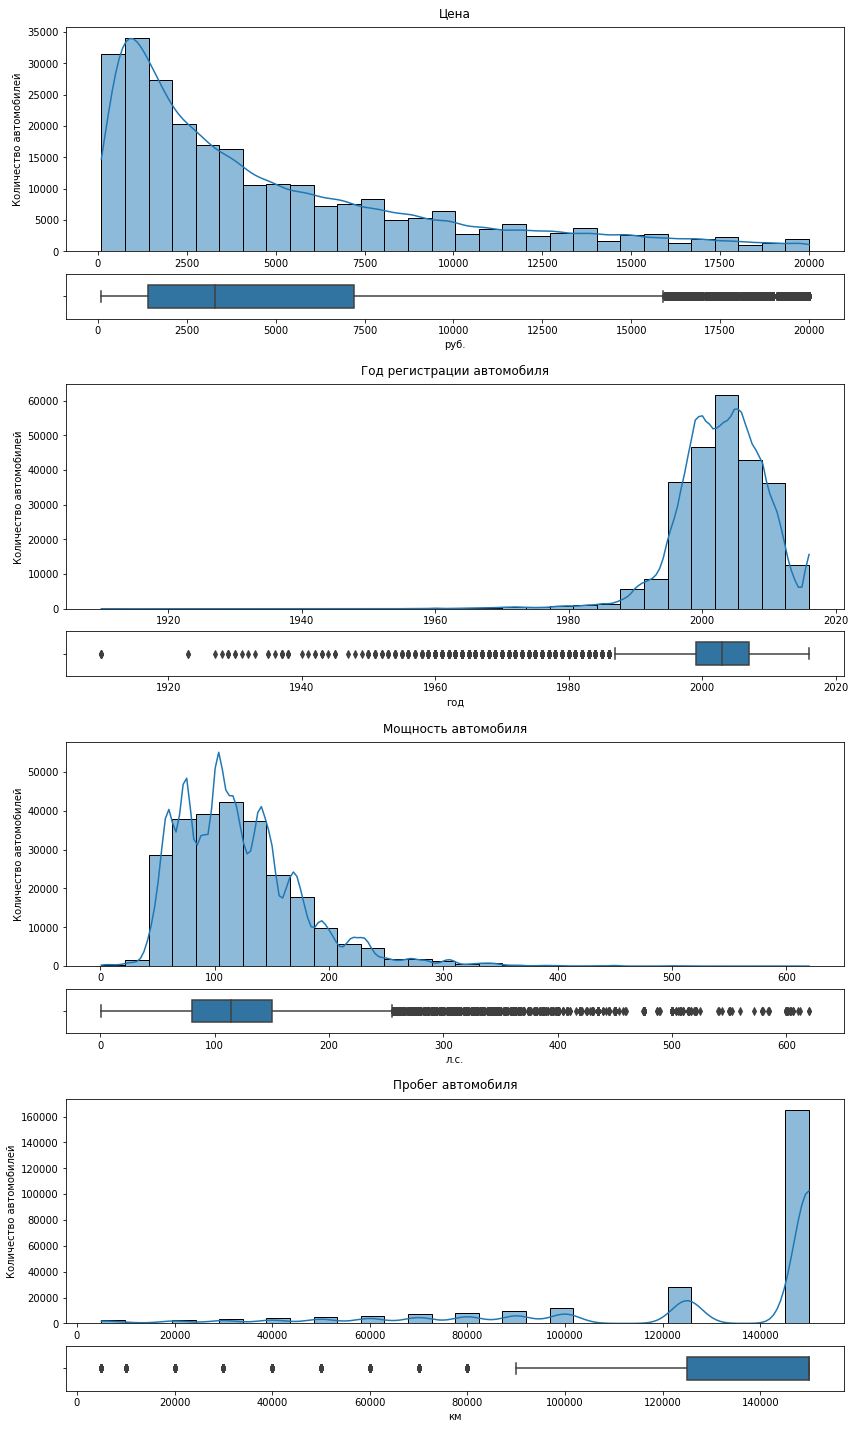

In [15]:
# Построим гистограммы и диаграмма размаха для всех непрерывных числовых столбцов таблицы на одном графике.

columns = hist_col  # Колонки для анализа
titles = ['Цена', 'Год регистрации автомобиля', 'Мощность автомобиля', 'Пробег автомобиля' ]  # Заголовки для осей
xlabels = ['руб.', 'год', 'л.с.', 'км']  # Подписи оси X


# Создаем фигуру с 4 рядами и 1 колонкой 
fig, axes = plt.subplots(len(columns), 1, figsize=(12, 20))

# Для каждого столбца создаем две оси (гистограмма + боксплот)
for i, col in enumerate(columns):
        
    # Разделяем текущую ось на две: верхнюю (гистограмма) и нижнюю (боксплот)
    ax_hist = axes[i]  # Гистограмма будет здесь
    ax_box = ax_hist.inset_axes([0, -0.3, 1, 0.2])  # Боксплот внизу
    
    # Гистограмма
    sns.histplot(data=df, x=col, ax=ax_hist, bins=30, kde=True)
    ax_hist.set_title(titles[i], pad=10)
    ax_hist.set_xlabel('')
    ax_hist.set_ylabel('Количество автомобилей')
    
    # Боксплот
    sns.boxplot(x=df[col], orient='h', ax=ax_box, width=0.5) 
    ax_box.set_xlabel(xlabels[i])
    ax_box.set_ylabel('')
    
    # Синхронизация осей X
    x_min = min(df[col].min(), ax_box.get_xlim()[0])
    x_max = max(df[col].max(), ax_box.get_xlim()[1])
    ax_hist.set_xlim(x_min, x_max)
    ax_box.set_xlim(x_min, x_max)

plt.tight_layout()
plt.show()


**Комментарии**

Гистограмма распределения целевого признака `Price` похожа на распределение Пуассона с тяготением к 1 квартилю и длинным хвостом вправо, существенных выбросов немного. Гистограмма распределения года регистрации автомобилей выглядит правдоподобно, основная масса автомобилей выпущена после 1990 г. У признаков мощности и пробега автомобиля присутствует множество выбросов, но основная масса значений вписываются в образ "среднестатистического автомобиля с пробегом".



In [16]:
# Функция для добавления подписей с процентами

def add_percentage_labels(ax):
    total = sum(p.get_height() for p in ax.patches)
    
    for p in ax.patches:
        height = p.get_height()
        percentage = f"{height/total*100:.1f}%"  # Вычисляем долю и преобразуем в строку с одним знаком после запятой
        
        if height > 0:  # Избегаем деления на ноль и отрицательных высот
            ax.annotate(
                percentage,
                xy=(p.get_x() + p.get_width() / 2, height),
                xytext=(0, 3),  # смещение вверх
                textcoords="offset points",
                ha='center',
                va='bottom'
            )

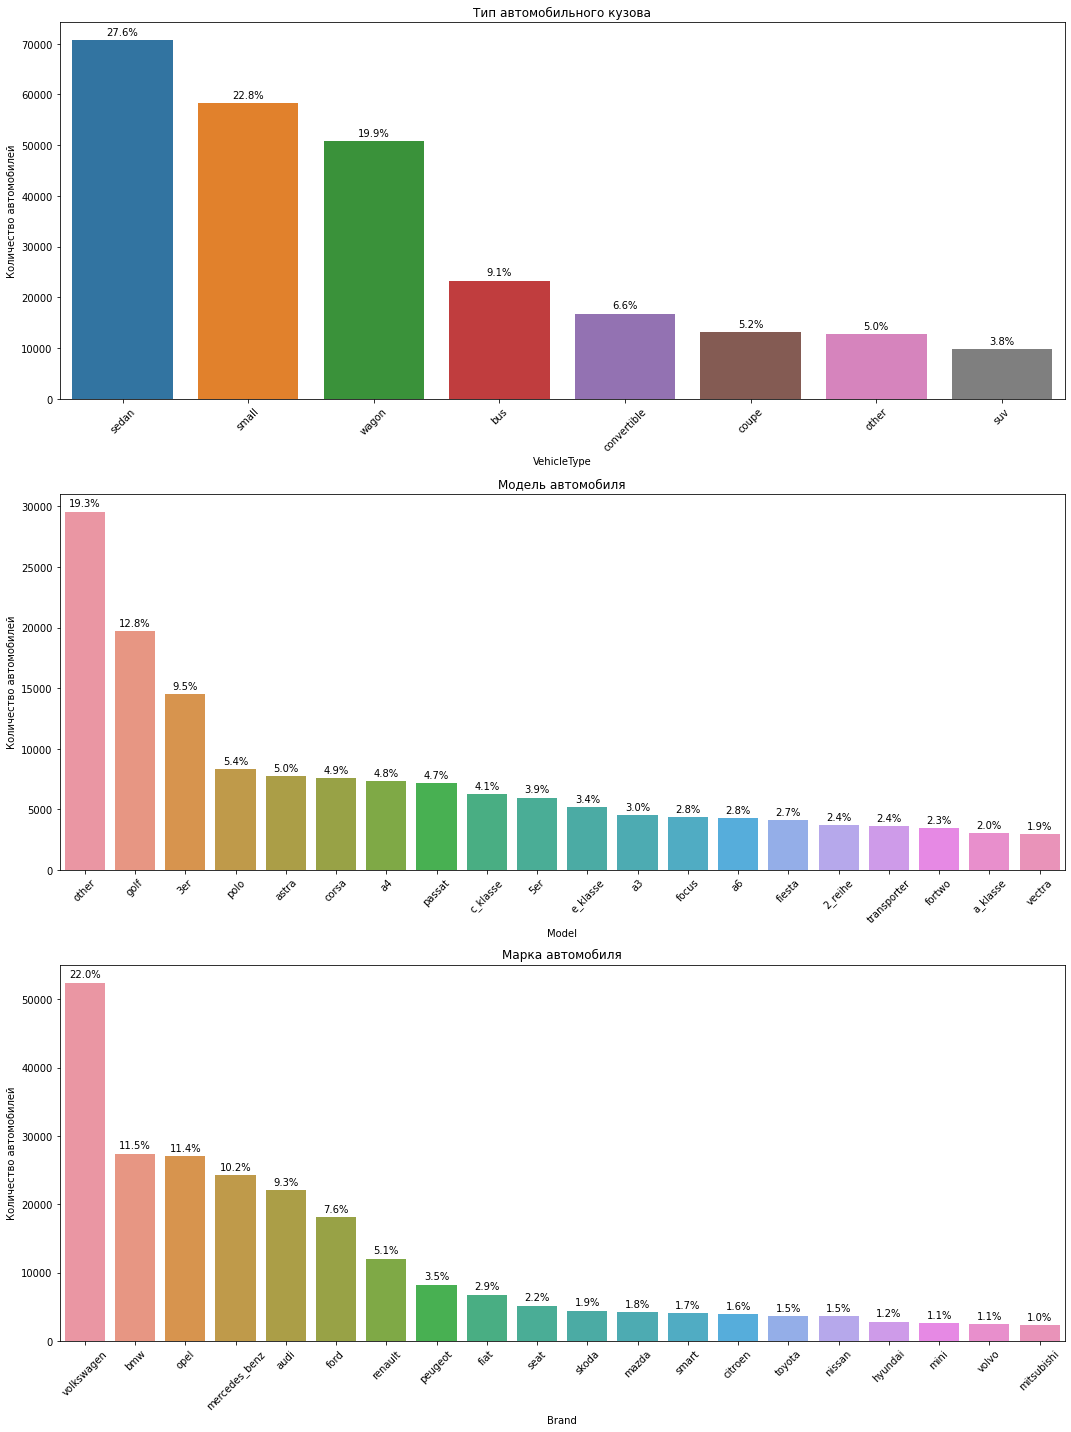

In [17]:
# Построим столбчатые диаграммы для категориальных столбцов таблицы с множеством значений на одном графике.

fig, axes = plt.subplots(3, 1, figsize=(15, 20)) # Создаем сетку из 3 подграфиков
axes = axes.flatten()  # Преобразуем массив двумерный в одномерный

columns = mult_col  # Колонки для анализа
titles = ['Тип автомобильного кузова', 'Модель автомобиля', 'Марка автомобиля']  # Заголовки для осей

for ax, col, title in zip(axes, columns, titles):
    order = df[col].value_counts().head(20).index  # Определяем порядок сортировки
    sns.countplot(data=df, x=col, ax=ax, order=order)
    ax.set(title=title, ylabel='Количество автомобилей')
    add_percentage_labels(ax)  # Добавляем подписи количества
    ax.tick_params(axis='x', rotation=45)  # Поворачиваем метки по оси X для лучшей читаемости
 

plt.tight_layout()
plt.show()


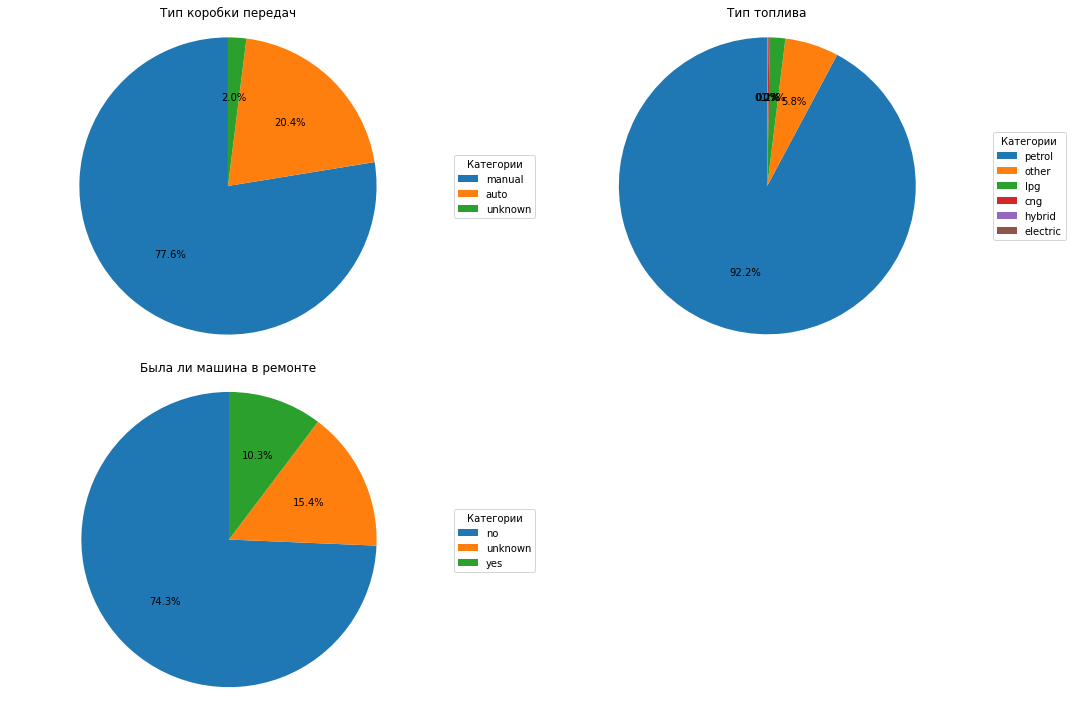

In [18]:
# Построим круговые диаграммы для всех категориальных столбцов на одном графике.

fig, axes = plt.subplots(2, 2, figsize=(15, 10))  # Создаем сетку из 2x2 подграфиков
axes = axes.flatten()  # Преобразуем массив двумерный в одномерный

columns = cat_col # Колонки для анализа
titles = ['Тип коробки передач', 'Тип топлива', 'Была ли машина в ремонте']  # Заголовки для осей

# Проход по колонкам и создание круговых диаграмм
for i, (col, title) in enumerate(zip(columns, titles)):
    if i >= len(axes):
        break
    
    counts = df[col].value_counts().sort_values(ascending=False)  # Подсчет количества записей для каждого значения
    labels = counts.index  # Метки категорий
    sizes = counts.values  # Доли значений
    
    # Построение круговой диаграммы
    wedges, texts, autotexts = axes[i].pie(sizes, labels=None, autopct='%1.1f%%', startangle=90)
    axes[i].legend(wedges, labels,
                   title="Категории",
                   loc="center left",
                   bbox_to_anchor=(1, 0, 0.5, 1))
    axes[i].set_title(title)
    axes[i].axis('equal')  # Устанавливаем равный масштаб осей, чтобы получился правильный круг

# Удаляем пустые места, если кол-во колонок меньше 4
if len(columns) < 4:
    for ax in axes[len(columns):]:
        ax.axis('off')    
    
plt.tight_layout()  
plt.show()


**Комментарии**

Изучая категориальные признаки в датафрейме, можно сделать следующие выводы:
- Среди типов автомобильных кузовов лидируют "sedan" (27.6%), "small" (22.8%), "wagon" (19.9%).
- Машины преимущественно продаются с механической коробкой передач (77.6%).
- Практически все автомобили (92.2%) используют топливо 'petrol' (бензин).
- Самыми популярным стали немецкие марки автомобилей: "volkswagen" (22%), "bmw"(11.5%), "opel"(11.4%), "mercedes_benz"(10.2%) и  "audi"(9.3%).
- Большинство машин (74.3%) не было в ремонте в момент продажи. 
В целом по месяцам регистрации автомобилей данные распределены примерно равномерно, а в некоторых других признаках наблюдается большой перевес в категориях.

In [19]:
# Создаём список с непрерывными признаками 

warnings.filterwarnings("ignore")
interval_cols = [
    'Price',
    'Power',
    'Kilometer'
]

# Рассчитываем матрицу корреляций phi-k

corr_matrix = df.phik_matrix(interval_cols=interval_cols)
display(corr_matrix)


,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Kilometer,FuelType,Brand,Repaired
Price,1.000000,0.267594,0.676427,0.279067,0.492048,0.568603,0.307980,0.122333,0.358701,0.353037
VehicleType,0.267594,1.000000,0.609854,0.265458,0.453660,0.909220,0.188700,0.246645,0.629777,0.228783
RegistrationYear,0.676427,0.609854,1.000000,0.192754,0.282156,0.653905,0.632138,0.280911,0.393293,0.353267
Gearbox,0.279067,0.265458,0.192754,1.000000,0.454021,0.618028,0.074626,0.222461,0.519501,0.269459
Power,0.492048,0.453660,0.282156,0.454021,1.000000,0.759438,0.116322,0.102558,0.555754,0.123941
Model,0.568603,0.909220,0.653905,0.618028,0.759438,1.000000,0.438772,0.337059,0.997870,0.238344
Kilometer,0.307980,0.188700,0.632138,0.074626,0.116322,0.438772,1.000000,0.100010,0.274445,0.243744
FuelType,0.122333,0.246645,0.280911,0.222461,0.102558,0.337059,0.100010,1.000000,0.204676,0.280557
Brand,0.358701,0.629777,0.393293,0.519501,0.555754,0.997870,0.274445,0.204676,1.000000,0.140414
Repaired,0.353037,0.228783,0.353267,0.269459,0.123941,0.238344,0.243744,0.280557,0.140414,1.000000


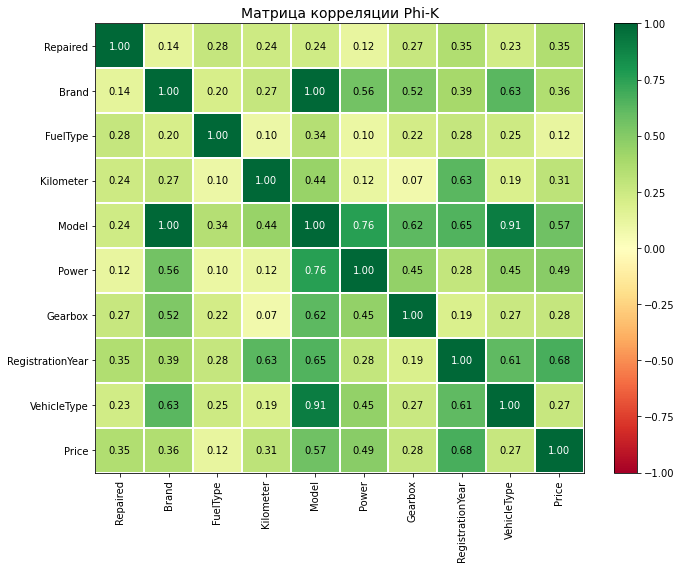

In [20]:
# Отображение корреляционной матрицы в виде тепловой карты

plot_correlation_matrix(corr_matrix.values,
                        x_labels=corr_matrix.columns,
                        y_labels=corr_matrix.index,
                        title='Матрица корреляции Phi-K',
                        figsize=(10,8))
plt.show()

**Комментарии**

На тепловой карте темно-зеленые и красные тона говорят о сильной линейной зависимости, а светло-зеленые, желтые и оранжевые — о слабой. Анализируя матрицу корреляции Phi-K, можно сделать вывод, что наиболее выраженная связь между целевым признаком `Price` у входных признаков `RegistrationYear` (0.68), `Model` (0.57), менее заметная у признаков `Power` (0.49), `Brand` (0.36), `Repaired` (0.35), `Kilometer`(0.31), `Gearbox` (0.28), `VehicleType` (0.27), а слабая у признака `FuelType` (0.12). У признаков `Brand` и `Model` - корреляция - 1, что свидетельствует о мультиколлинеарности, один из этих признаков необходимо удалить. Признак `Model` также имеет высокую корреляцию с признаком `VehicleType`, что логично, так как модель автомобиля характеризуется определенными типами кузова.  


In [21]:
# Удалим столбец Brand, чтобы избавиться от мультиколлинеарности

df = df.drop('Brand', axis=1)

In [22]:
# Повторно проверим и удалим явные дубликаты

print('Количество явных дубликатов в датафрейме df:', df.duplicated().sum())
df.drop_duplicates(inplace=True)
print('Количество явных дубликатов в датафрейме df после удаления:', df.duplicated().sum())

Количество явных дубликатов в датафрейме df: 241
Количество явных дубликатов в датафрейме df после удаления: 0


In [23]:
# Оценим объем удаленных данных

print('Размер датафрейма до предобработки: (354369, 16)')
print('Размер датафрейма после предобработки:', df.shape)

Размер датафрейма до предобработки: (354369, 16)
Размер датафрейма после предобработки: (255338, 9)


**Выводы**

В настоящем разделе мы провели первичную предобработку данных: проверили и обработали дубликаты и аномалии, заполнили пропуски, удалили неинформативные признаки. Удаленные данные составили около 30% всего датасета. По результатам анализа и подготовки данных для обучения модели можно сделать следующие выводы:
- Распределение целевого признака `Price` похоже на распределение Пуассона с тяготением к 1 квартилю и длинным хвостом вправо, существенных выбросов немного. 
- Медианный пробег автомобилей 150 000 км.
- Основная масса автомобилей выпущена после 1990 г.
- Среди типов автомобильных кузовов лидируют "sedan" (27.6%), "small" (22.8%), "wagon" (19.9%).
- Машины преимущественно продаются с механической коробкой передач (77.6%).
- Практически все автомобили (92.2%) используют топливо 'petrol' (бензин).
- Самыми популярным стали немецкие марки автомобилей: "volkswagen" (22%), "bmw"(11.5%), "opel"(11.4%), "mercedes_benz"(10.2%) и  "audi"(9.3%).
- Большинство машин (74.3%) не было в ремонте в момент продажи. 
- Наиболее выраженная связь между целевым признаком `Price` у входных признаков `RegistrationYear` (0.68), `Model` (0.57) и `Power` (0.49).

Утечка целевого признака не обнаружена. Будем учитывать вышеописанные особенности данных при моделировании и подборе параметров, также стоит применить масштабирование.

## Обучение моделей

In [24]:
# Удаляем целевой признак

X_auto = df.drop('Price', axis=1)

# Сохраняем целевой признак

y_auto = df['Price']

In [25]:
# Разбиваем данные на обучающую и тестовую выборки в соотношении 75:25.

X_train, X_test, y_train, y_test = train_test_split(
        X_auto,
        y_auto,
        random_state=RANDOM_STATE,
        test_size=0.25,
    )

In [27]:
def ml_model(X_train, y_train, pipe, param_grid):
    
    start_time = time.time()  # начинаем замер общего времени
    
    # Поиск наилучшей модели
    randomized_search = RandomizedSearchCV(
        estimator=pipe,
        param_distributions=param_grid,
        n_iter=30,
        cv=5,
        scoring='neg_root_mean_squared_error',
        random_state=RANDOM_STATE,
        n_jobs=-1,
        error_score="raise",
    )
    
    randomized_search.fit(X_train, y_train)
    
    end_time = time.time()  # заканчиваем замер общего времени
    all_time = end_time - start_time
    print(f"Время полного процесса поиска: {all_time:.2f} секунд")
    
    # Извлекаем подробный отчет
    results_df = pd.DataFrame(randomized_search.cv_results_)
    
    # Оставляем нужные колонки
    selected_columns = [
        'mean_test_score',       # среднее значение оценки теста
        'rank_test_score',       # ранг модели среди остальных
        'params',                # параметры модели
        'mean_fit_time',         # среднее время обучения
        'mean_score_time'        # среднее время предсказания
    ]
    
    report = results_df[selected_columns]
    
    # Приводим отрицательные значения обратно к положительным (так как использовался neg_root_mean_squared_error)
    report['mean_test_score'] *= -1
    
    # Показываем отчёт
    print("Отчёт по результатам поиска:\n")
    display(report.sort_values(by=['rank_test_score'], ascending=True).reset_index(drop=True))
    
    # Информация о лучшей модели
    best_model = randomized_search.best_estimator_
    best_params = randomized_search.best_params_
    best_rmse = (-1) * randomized_search.best_score_
    
    print('Лучшая модель:\n')
    print(best_model)
    print('Параметры лучшей модели:', best_params)
    print('RMSE лучшей модели на кросс-валидации:', best_rmse)
    
    return randomized_search

### Подготовка данных в пайплайне

In [28]:
# Определяем тип признаков для пайплайна

ohe_columns = ['VehicleType', 'Gearbox',  'FuelType', 'Model', 'Repaired']
num_columns = ['RegistrationYear', 'Power', 'Kilometer']

In [29]:
# Создаём пайплайн для подготовки признаков из списка ohe_columns: заполнение пропусков и OHE-кодирование

ohe_pipe = Pipeline([
    ('ohe', OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)),
    ('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent'))
])

In [30]:
# Создаём общий пайплайн для подготовки данных

data_preprocessor = ColumnTransformer(
    [('ohe', ohe_pipe, ohe_columns),
     ('num', MinMaxScaler(), num_columns)
    ], 
    remainder='passthrough'
)

In [31]:
# Cоздаём пайплайн для модели LinearRegression: подготовка данных и модель

pipe_lin = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LinearRegression())
])

In [32]:
# Создаем сетку гиперпараметров для модели линейной регрессии

param_grid_lin = [
    {
        'models': [LinearRegression()],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(),  RobustScaler(), 'passthrough']  
    }
]

In [33]:
# Cоздаём пайплайн для модели DecisionTreeRegressor: подготовка данных и модель

pipe_tree = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeRegressor(random_state=RANDOM_STATE))
])

In [34]:
# Создаем сетку гиперпараметров для модели DecisionTreeRegressor

param_grid_tree = [
    {
        'models': [DecisionTreeRegressor(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 15),
        'models__min_samples_leaf': range(1, 8),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), RobustScaler(), 'passthrough']  
    }
]

In [35]:
# Cоздаём пайплайн для модели LGBMRegressor: подготовка данных и модель

pipe_lgbm = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', LGBMRegressor(random_state=RANDOM_STATE, verbose=-1))
])

In [36]:
# Создаем сетку гиперпараметров для модели LGBMRegressor

param_grid_lgbm = [
    {
    'models': [LGBMRegressor(random_state=RANDOM_STATE, verbose=-1)],
    'models__n_estimators': range(50, 100, 10),
    'models__max_depth': range(3, 8)
    }
]

### Обучение моделей

In [37]:
%%time
# Обучим модель линейной регрессии

model_lin = ml_model(X_auto, y_auto, pipe_lin, param_grid_lin)

Время полного процесса поиска: 437.51 секунд
Отчёт по результатам поиска:



,mean_test_score,rank_test_score,params,mean_fit_time,mean_score_time
0,2740.214226,1,"{'preprocessor__num': MinMaxScaler(), 'models'...",19.041225,0.548152
1,2740.214226,1,"{'preprocessor__num': RobustScaler(), 'models'...",19.815548,0.557842
2,2740.214226,3,"{'preprocessor__num': StandardScaler(), 'model...",19.610640,0.544840
3,2740.214226,4,"{'preprocessor__num': 'passthrough', 'models':...",21.429552,0.540014


Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Repaired']),
                                          

In [38]:
%%time
# Обучим модель DecisionTreeRegressor

model_tree = ml_model(X_train, y_train, pipe_tree, param_grid_tree)

Время полного процесса поиска: 1099.80 секунд
Отчёт по результатам поиска:



,mean_test_score,rank_test_score,params,mean_fit_time,mean_score_time
0,1916.688590,1,"{'preprocessor__num': RobustScaler(), 'models_...",8.132323,0.362327
1,1916.828747,2,"{'preprocessor__num': StandardScaler(), 'model...",8.206522,0.363266
2,1933.579714,3,"{'preprocessor__num': 'passthrough', 'models__...",8.041102,0.355869
3,1937.574338,4,"{'preprocessor__num': StandardScaler(), 'model...",7.871711,0.349626
4,1962.586229,5,"{'preprocessor__num': 'passthrough', 'models__...",7.977411,0.361987
5,1965.184538,6,"{'preprocessor__num': RobustScaler(), 'models_...",7.879014,0.355744
6,1970.662079,7,"{'preprocessor__num': RobustScaler(), 'models_...",8.125495,0.354303
7,2028.287801,8,"{'preprocessor__num': 'passthrough', 'models__...",7.626178,0.354690
8,2036.223647,9,"{'preprocessor__num': 'passthrough', 'models__...",7.707868,0.356568
9,2036.250533,10,"{'preprocessor__num': MinMaxScaler(), 'models_...",7.561964,0.350282


Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Repaired']),
                                          

In [39]:
%%time

# Обучим модель LGBMRegressor

model_lgbm = ml_model(X_train, y_train, pipe_lgbm, param_grid_lgbm)

Время полного процесса поиска: 2884.63 секунд
Отчёт по результатам поиска:



,mean_test_score,rank_test_score,params,mean_fit_time,mean_score_time
0,1806.324184,1,"{'models__n_estimators': 90, 'models__max_dept...",12.853312,0.603530
1,1817.511315,2,"{'models__n_estimators': 80, 'models__max_dept...",6.597400,0.562982
2,1825.357677,3,"{'models__n_estimators': 90, 'models__max_dept...",6.618465,0.597711
3,1831.470164,4,"{'models__n_estimators': 70, 'models__max_dept...",6.692908,0.525009
4,1836.553555,5,"{'models__n_estimators': 80, 'models__max_dept...",11.114831,0.564148
5,1847.799885,6,"{'models__n_estimators': 60, 'models__max_dept...",6.218326,0.541012
6,1849.944857,7,"{'models__n_estimators': 70, 'models__max_dept...",6.478740,0.562119
7,1855.775034,8,"{'models__n_estimators': 90, 'models__max_dept...",6.675537,0.541440
8,1865.511083,9,"{'models__n_estimators': 60, 'models__max_dept...",6.038282,0.502715
9,1866.973328,10,"{'models__n_estimators': 80, 'models__max_dept...",6.244287,0.558262


Лучшая модель:

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(drop='first',
                                                                                 handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent'))]),
                                                  ['VehicleType', 'Gearbox',
                                                   'FuelType', 'Model',
                                                   'Repaired']),
                                          

**Выводы**

Для поиска лучших параметров моделей для предсказания цены автомобиля был использован инструмент `RandomizedSearchCV`, который анализировал различные параметры для моделей `LinearRegression()`, `DecisionTreeRegressor()` и `LGBMRegressor()`. 

Лучшей стала модель со следующими параметрами: LGBMRegressor(max_depth=7, n_estimators=90, random_state=42,verbose=-1).

## Анализ моделей

In [40]:
%%time
# Проверим работу модели LightGBM на тестовой выборке

best_model_lgbm = model_lgbm.best_estimator_
y_test_pred_lgbm = best_model_lgbm.predict(X_test)
mse_lgbm = mean_squared_error(y_test, y_test_pred_lgbm)
rmse_lgbm = math.sqrt(mse_lgbm)
print('RMSE на тестовой выборке:', rmse_lgbm)

RMSE на тестовой выборке: 1820.6695343854637
CPU times: user 728 ms, sys: 216 ms, total: 945 ms
Wall time: 891 ms


**Выводы**

Для выбора лучшей модели заказчику было важно учитывать качество (значение метрики RMSE должно быть меньше 2500) и скорость предсказания, а также время обучения.

Достигнув метрики RMSE в 1806 на кросс-валидации, и 1820 на тестовых данных, лучше всех себя показала модель `LGBMRegressor`. 
Обучение модели заняло 12.853312 секунд, а время предсказания 0.603530 секунды.  	

Модель LightGBM справилась лучше линейной регрессии и дерева решений, так как увереннее работает при нелинейной зависимости признаков, а, учитывая матрицу корреляции, можно сказать, что в наших данных признаков с такой зависимостью много. Более того эта модель эффективно обрабатывает шумы и неоднородности данных, что обусловлено наличием методов регуляризации и мощным механизмом ансамблевого обучения. Однако бустинг обучается значительно дольше других моделей, но и точность предсказания у этой модели выше, поэтому рекомендуется ее использование для задачи определения цены автомобиля.


## Выводы

Для настоящего проекта нам были предоставлены данные сервиса по продаже автомобилей с пробегом «Не бит, не крашен», который разрабатывает приложение для привлечения новых клиентов. В нём можно быстро узнать рыночную стоимость своего автомобиля. 

**Цель исследования**: Построить модель машинного обучения для определения стоимости автомобиля на основе исторических данных: технические характеристики, комплектации и цены.

В **первом разделе** мы загрузили данные, изучили общую информацию, и подготовили их к дальнейшему обучению модели. Проверили и обработали дубликаты и аномалии, заполнили пропуски, удалили неинформативные признаки. Для анализа нам был предоставлен датасет, который включал данные об автомобилях со следующими признаками:
- `DateCrawled` — дата скачивания анкеты из базы
- `VehicleType` — тип автомобильного кузова
- `RegistrationYear` — год регистрации автомобиля
- `Gearbox` — тип коробки передач
- `Power` — мощность (л. с.)
- `Model` — модель автомобиля
- `Kilometer` — пробег (км)
- `RegistrationMonth` — месяц регистрации автомобиля
- `FuelType` — тип топлива
- `Brand` — марка автомобиля
- `Repaired` — была машина в ремонте или нет
- `DateCreated` — дата создания анкеты
- `NumberOfPictures` — количество фотографий автомобиля
- `PostalCode` — почтовый индекс владельца анкеты (пользователя)
- `LastSeen` — дата последней активности пользователя
- `Price` — цена (евро) — **целевой признак**

По результатам анализа и подготовки данных для обучения модели можно сделать следующие выводы:
- Распределение целевого признака `Price` похоже на распределение Пуассона с тяготением к 1 квартилю и длинным хвостом вправо, существенных выбросов немного. 
- Медианный пробег автомобилей 150 000 км.
- Основная масса автомобилей выпущена после 1990 г.
- Среди типов автомобильных кузовов лидируют "sedan" (27.6%), "small" (22.8%), "wagon" (19.9%).
- Машины преимущественно продаются с механической коробкой передач (77.6%).
- Практически все автомобили (92.2%) используют топливо 'petrol' (бензин).
- Самыми популярным стали немецкие марки автомобилей: "volkswagen" (22%), "bmw"(11.5%), "opel"(11.4%), "mercedes_benz"(10.2%) и  "audi"(9.3%).
- Большинство машин (74.3%) не было в ремонте в момент продажи. 
- Наиболее выраженная связь между целевым признаком `Price` у входных признаков `RegistrationYear` (0.68), `Model` (0.57) и `Power` (0.49).

Во **втором разделе** для поиска лучших параметров моделей для предсказания цены автомобиля был использован инструмент `RandomizedSearchCV`, который анализировал различные параметры для моделей `LinearRegression()`, `DecisionTreeRegressor()` и `LGBMRegressor()`. Лучшей стала модель со следующими параметрами: LGBMRegressor(max_depth=7, n_estimators=90, random_state=42,verbose=-1).

В **третьем разделе** мы провели анализ работы отобранной модели на тестовой выборке данных. Для выбора лучшей модели заказчику было важно учитывать качество и скорость предсказания, а также время обучения. Достигнув метрики RMSE в 1806 на кросс-валидации, и 1820 на тестовых данных, лучше всех себя показала модель `LGBMRegressor`. Обучение модели заняло 12.853312 секунд, а время предсказания 0.603530 секунды. Точность предсказания у  модели бустинга выше, поэтому рекомендуется ее использование для задачи определения цены автомобиля.

Таким образом, по итогам проведенного анализа была построена модель машинного обучения, способная предсказать рыночную стоимость  автомобиля по техническим характеристикам и комплектации.
